In [177]:
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import importlib
from datetime import date
from sklearn.cluster import SpectralBiclustering
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, Math, Latex
from ipypublish import nb_setup
import drought_ibf_utility as ibf
importlib.reload(ibf)
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('seaborn-darkgrid')
sns.set(font_scale=1.2)
pd = nb_setup.setup_pandas(escape_latex=False)

# Summary
Here we train and optimize a logistic regression model to predict the occurrence of droughts in Uganda based of meteorological data. The precipitation and the **E**nhanced **V**egitation **I**ndex (EVI) turn out to be the most important drought predictors among all the meteorological quantities that we studied. The model is able to capture 70 percent of the reported droughts in our historical data, which would make it a potentially useful model to monitor and predict droughts in Uganda.

# Data collection

We are going to construct a model to predict the occurrence of the drought in Uganda, using satellite meteorological satellite data. 

The meteorological parameters that serves as drought indicators, and to which we refer as **features**, are collected using the [Google Earth engine](https://developers.google.com/earth-engine/python_install) by this [python script](https://github.com/rodekruis/Drought_IBF/blob/master/GoogleEarthEngine/GEE_get_data.py), and are listed bellow

  
- [**NDVI:**](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A2) *'***N***ormalized ***D***ifference ***V***egitation ***I***ndex'* (scale by 0.0001).    
- [**EVI:**](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13A2) *'***E***nhanced ***V***egitation ***I***ndex'* (scale by 0.0001). 
- [**precipitation:**](https://developers.google.com/earth-engine/datasets/catalog/TRMM_3B43V7#bands): Rainfall in mm/hrs. Name in our dataset: '`precipitation per hour v1`'.
- [**hourlyPrecipRate:**](https://developers.google.com/earth-engine/datasets/catalog/JAXA_GPM_L3_GSMaP_v6_operational) Rainfall measured in mm/hrs. Name in our dataset: '`precipitation per hour v2`'. 
- [**LST_Day_1km:**](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1) Land surface temperature during daytime in  50 Kelvins (multiply number by 0.02 to get Kelvins). Name in our dataset: '`surface temperature daytime`'.
- [**LST_Night_1km:**](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1) Land surface temperature during daytime in  50 Kelvins (multiply number by 0.02 to get Kelvins). Name in our dataset: '`surface temperature nighttime`'.
- [**Evap_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Evapotranspiration measured in kg m^{-2} s^{-1}. Name in our dataset: '`evapotranspiration`'.
- [**Rainf_f_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Precipitation rate measured in kg m^{-2} s^{-1}  Name in our dataset: '`rainfall`'. 
- [**SoilMoi00_10cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil moisture (0 - 10 cm underground) in m^3 m-3. Name in our dataset: '`SoilMoisture00 10cm`'.
- [**SoilMoi10_40cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil moisture (0 - 10 cm underground) in m^3 m-3. Name in our dataset: '`SoilMoisture10 40cm`'.
- [**SoilMoi40_100cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil moisture (0 - 10 cm underground) in m^3 m-3. Name in our dataset: '`SoilMoisture40 100cm`'.
- [**SoilMoi100_200cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil moisture (0 - 10 cm underground) in m^3 m-3. Name in our dataset: '`SoilMoisture100 200cm`'.
- [**SoilTemp00_10cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil temperature (0 - 10 cm underground) in K. Name in our dataset: '`SoilTemperature00 10cm`'.
- [**SoilTemp10_40cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil temperature (10 - 40 cm underground) in K. Name in our dataset: '`SoilTemperature10 40cm`'. 
- [**SoilTemp40_100cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil temperature (40 - 100 cm underground) in K. Name in our dataset: '`SoilTemperature40 100cm`'.
- [**SoilTemp100_200cm_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Soil temperature (100 - 200 cm underground) in K. Name in our dataset: '`SoilTemperature100 200cm`'.
- [**Tair_f_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Near surface air temperature in K. Name in our dataset: '`air temperature`'.
- [**Wind_f_tavg:**](https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001) Near surface wind speed in m/s. Name in our dataset: '`wind speed`'.  
- [**SPEI** columns:](https://spei.csic.es/) We calculated the *‘***S***tandardized ***P***recipitation-***E***vapotranspiration ***I***ndex’* from the columns '`rainfall`' and '`evapotranspiration`' in our dataset, using the published [R package](https://spei.csic.es/tools.html). We have used different *scale* parameters from 1 to 12 months, generating the columns '`SPEI 1month`' to '`SPEI 12month`'. The R script to perform this calculation can be find [here](https://github.com/rodekruis/Drought_IBF/blob/master/Model%20Event%20Data/SPEI_satellite/calc_SPEI.R).

All features were averaged over each district (i.e.  admin. level 1), and either averaged or summed in successive one-month intervals (see the [python script](https://github.com/rodekruis/Drought_IBF/blob/master/GoogleEarthEngine/GEE_get_data.py) for details).

The target variable that we are trying to predict, to which we refer to as **labels**, is the occurrence of droughts at a certain time point/period in a particular district. This would be a binary (i.e. Boolean) variable, taking the value 'True' when a drought has occurred, and 'False' when no drought is reported. The data comes from two different sources: the Red Cross desinventar and news articles, both can be found [here](https://rodekruis.sharepoint.com/sites/510-CRAVK-510/Gedeelde%20%20documenten/Forms/AllItems.aspx?RootFolder=%2Fsites%2F510%2DCRAVK%2D510%2FGedeelde%20%20documenten%2F%5BCTRY%5D%20Uganda%2F2%2D%20IBF%20DROUGHT%20UGANDA%2FDROUGHT%20EVENTS%20%26%20IMPACT%20ANALYSIS&FolderCTID=0x012000D122CA8FA5B68345A13A32EDAA653915). We chose to combine the two sources together to build the label variable. This is represented by the column '`drought reported`' in the dataset. 

We merged all the features and labels into a single dataset using this [Jupyter notebook](https://github.com/rodekruis/Drought_IBF/blob/master/Model%20Event%20Data/combining%20satellite%20data%20with%20desinventar%20events%20and%20news%20article%20events%20.ipynb). The resultant dataset can be found [here](https://github.com/rodekruis/Drought_IBF/blob/master/Model%20Event%20Data/datasets/Droughts_satelite_and_events.csv). Each row of the dataset corresponds to a unique pair of date and district.

In [16]:
phath='./datasets/'
filename='Droughts_satelite_and_events.csv'
full_data = pd.read_csv(phath + filename, index_col=False)
Uganda_data = full_data[full_data.Country == 'Uganda'].copy()


# Data preprocessing

We consider the bimodal [agricultural calendar for Uganda](https://fews.net/east-africa/uganda) of Uganda as shown in Figure \ref{fig:calendar} which has two harvest seasons per year: the first one during June and July, and the second one in November and December.  

![agricultural calendar for Uganda](./seasonal-calendar-uganda.png){#fig:calendar}

We set as our goal to predict weather a drought occurs or not within each harvest season, based on the meteorological data in the three-month period preceding the season. To this end we redefine the label variable to have the value `True` if a drought is reported in any of the two months of the season, and `False` otherwise. We also average all the meteorological data, except SPEI, over the preceding three-month period and use them as features for our model. For SPEI we use the column '` SPEI 3month`' and take the data points that correspond to the three-month period before each harvest season. We then normalize all features except `SPEI` per district and season. This means that for any given district and season, we calculate the mean and the standard deviation of each feature during all years, and then standardize the feature by subtracting the mean and dividing by the standard deviation. The `SPEI` feature is already normalized by construction.  
The transformed dataset can be downloaded from [here](https://github.com/rodekruis/Drought_IBF/blob/master/Model%20Event%20Data/datasets/Uganda_seasonal_normalized.csv). Each row is indicated by a unique triple of district, year and season. The first harvest season is indicated by `6_7` and the second one by `11_12`.

In [17]:
data = ibf.prepare_Uganda_data(save=True)

data.head()

,year,District,Season,EVI,NDVI,SPEI 3month,SoilMoisture00 10cm,SoilMoisture10 40cm,SoilMoisture100 200cm,SoilMoisture40 100cm,...,SoilTemperature40 100cm,air temperature,evapotranspiration,precipitation per hour v1,precipitation per hour v2,rainfall,surface temperature daytime,surface temperature nighttime,wind speed,drought reported
0,2000,ABIM,11_12,0.635496,0.232554,0.946693,0.876312,0.736812,0.199678,0.605763,...,-0.552902,-0.435935,1.208654,1.601028,-0.469460,1.336204,-0.151764,-1.343323,-0.412148,False
1,2000,ABIM,6_7,-1.590836,-1.720571,0.075238,-1.302612,-1.262019,-1.113239,-0.937505,...,1.414168,1.570308,-0.740945,-0.358292,-1.030145,-0.388903,1.260564,0.032762,0.306375,False
2,2000,ADJUMANI,11_12,-1.085335,-1.260320,-0.606487,-0.724946,-0.683251,-0.722124,-0.829818,...,0.199455,-0.221168,-1.138716,0.041021,-2.093348,-1.024165,1.721439,-1.782573,-0.412293,False
3,2000,ADJUMANI,6_7,-2.697474,-3.056846,-0.816605,-0.872943,-0.161562,0.243240,0.000243,...,1.332993,1.546512,-0.115219,-1.671680,-1.859843,-0.681410,2.350867,-0.480881,0.608132,False
4,2000,AGAGO,11_12,1.149972,-0.070580,0.824262,0.874588,0.793872,0.624983,0.710458,...,-0.539216,-0.380892,1.126550,1.366786,0.265181,0.963633,-0.414698,-2.063056,-0.467823,False


In [18]:
id_cols = ['year','District','Season']
label_name = 'drought reported'
All_features = list(data.drop(labels=id_cols+[label_name],axis=1).columns)
selected_features = All_features

As a final step of preparing the training data, we decided to only keep those rows in the dataset that correspond to either a year with a reported drought or a year preceding/following a drought. This will potentially reduce the noise in the data due to the droughts that have actually happened but remained unreported.

In [19]:
reduced_data = ibf.reduce_data(data,label_name)

# Data exploration

## Correlations among the features

Many of the features in our dataset are strongly correlated. To investigate this, we used a biclustering algorithm to divide the features into three separate groups. Features within a group correlate strongly with each other, while the correlation between features from different groups is weaker. Figure \ref{corr_mat} Shows the resultant correlation matrix, where the heatmap represents the absolute value of the correlation. We can see that the soil moisture and soil temperature features all correlate strongly with each other, as expected. Vegetation indices EVI and NDVI correlate well with each other, with air and surface temperatures, and with the soil temperature (but not with the soil moisture). Surprisingly the feature related to precipitation, namely '`rainfall`', '` precipitation_per_hour_v1`' and '` precipitation_per_hour_v2`', do not correlate well with each other. The reason for this is not clear for us.

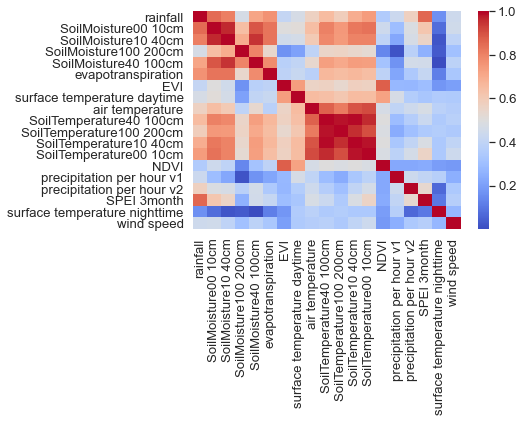

In [113]:
features = reduced_data[All_features].copy()
feature_corr = features.corr().abs()

bicluster_model = SpectralBiclustering(n_clusters=3, method='log',
                             random_state=0)
bicluster_model.fit(feature_corr)
feature_corr_sorted = feature_corr.values[np.argsort(bicluster_model.row_labels_),:]
feature_corr_sorted = feature_corr_sorted[:, np.argsort(bicluster_model.column_labels_)]
rows = feature_corr.columns[np.argsort(bicluster_model.row_labels_)]
cols = feature_corr.columns[np.argsort(bicluster_model.column_labels_)]
feature_corr_sorted = pd.DataFrame(feature_corr_sorted,index=rows,columns=cols)
sns.heatmap(feature_corr_sorted,cmap='coolwarm');
loc,labels =plt.xticks()
plt.yticks(ticks=loc,labels=list(labels));

The correlation plots among features within each of the three groups are shown in Figures \ref{pairplot1} to \ref{pairplot3}.

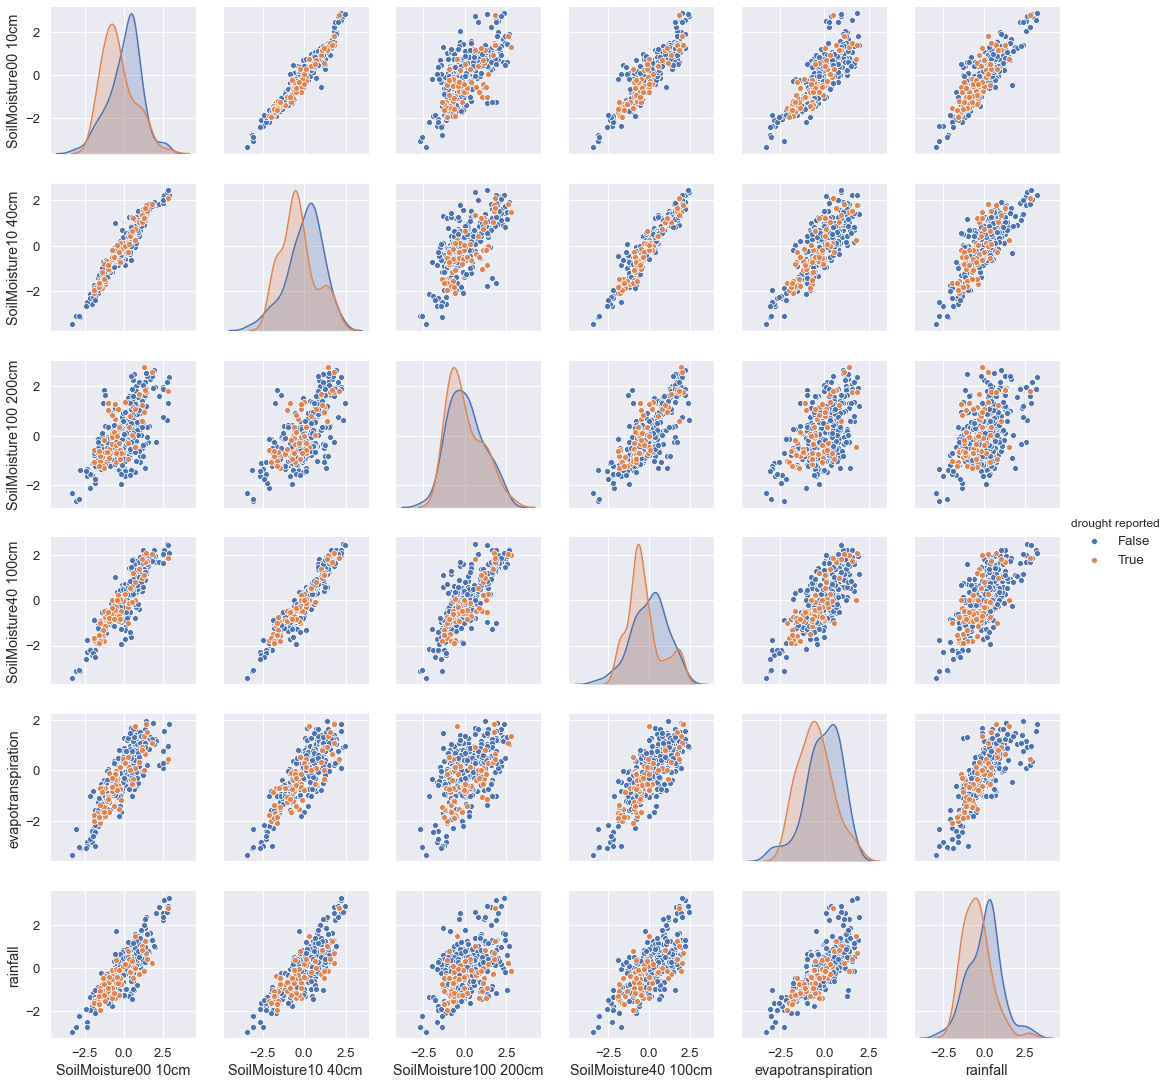

In [114]:
gruop_0 = feature_corr.columns[bicluster_model.row_labels_==0] 
sns.pairplot(reduced_data, vars=gruop_0, hue=label_name);

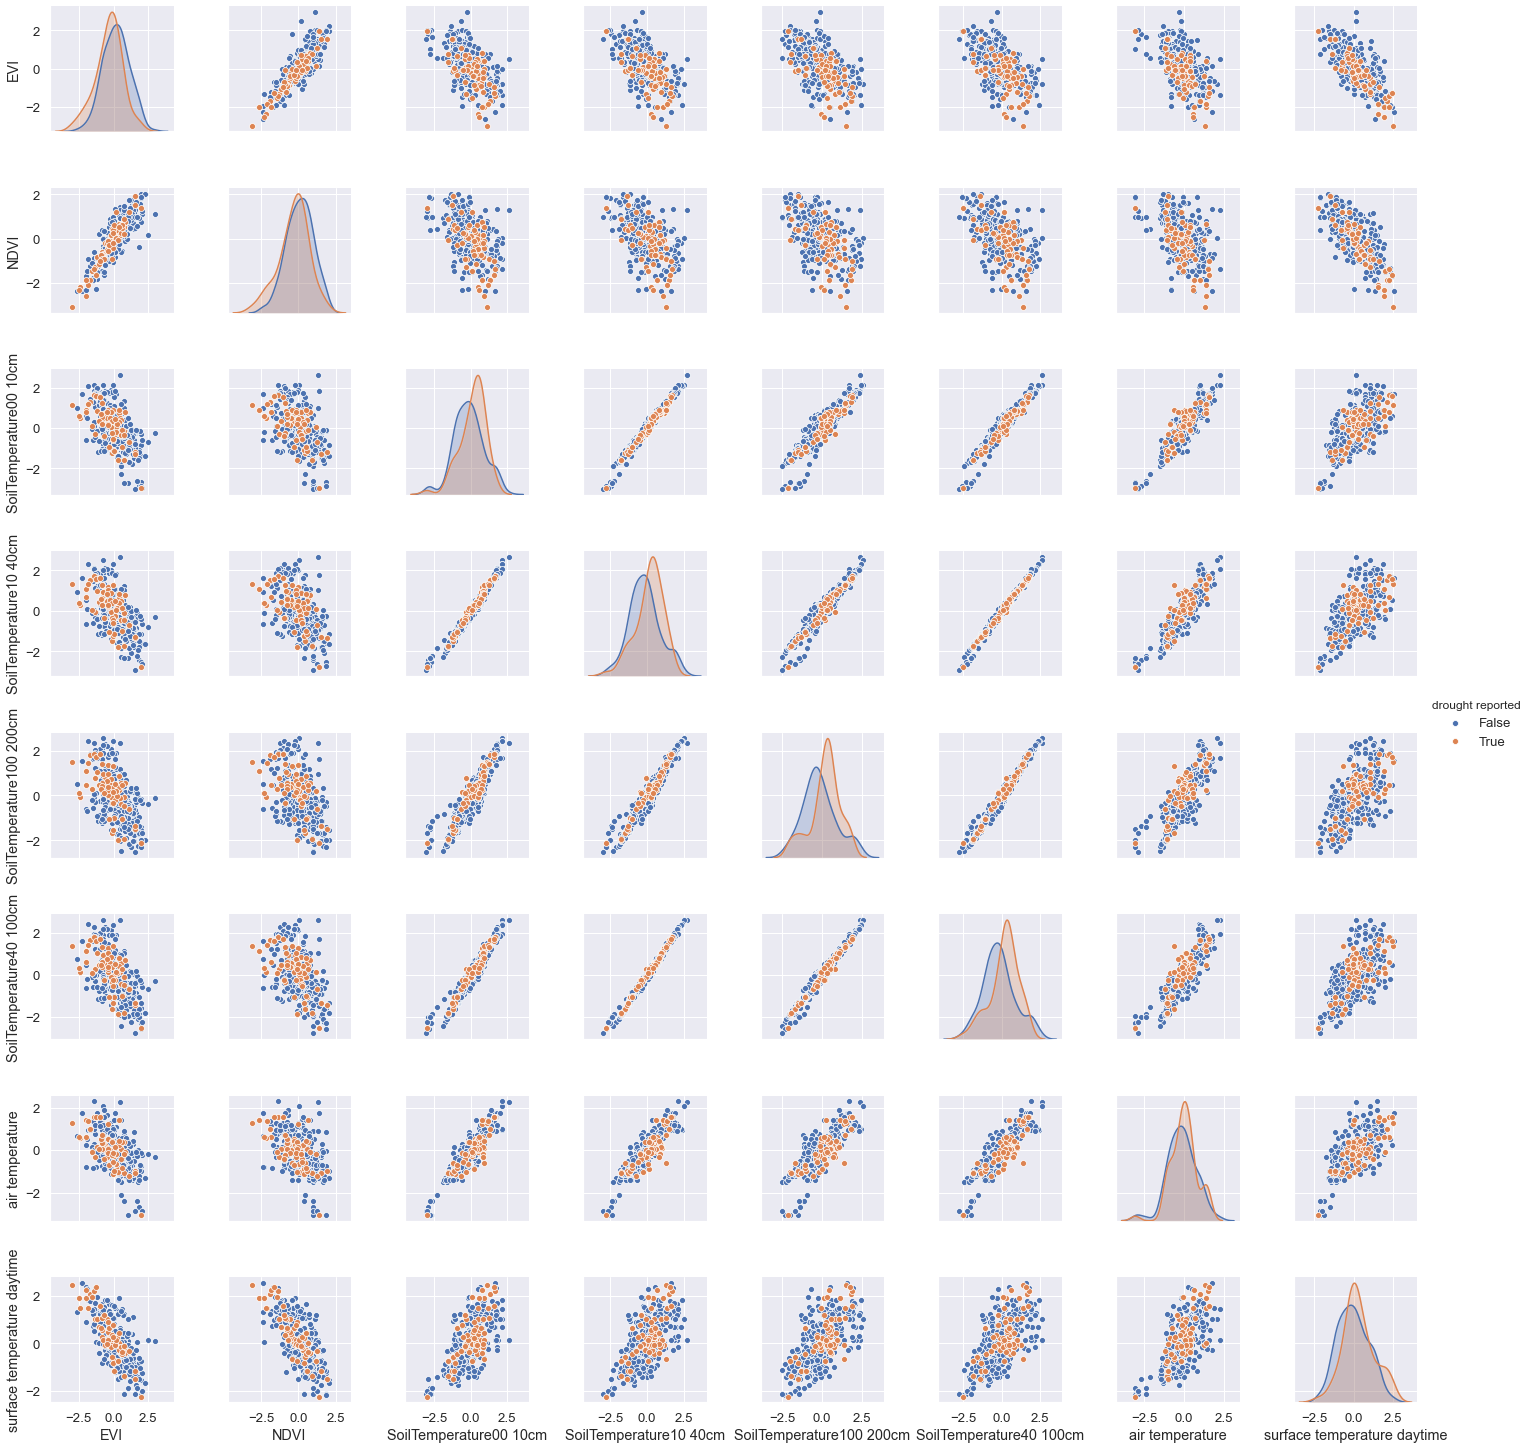

In [59]:
gruop_1 = feature_corr.columns[bicluster_model.row_labels_==1]
sns.pairplot(reduced_data, vars=gruop_1, hue=label_name);

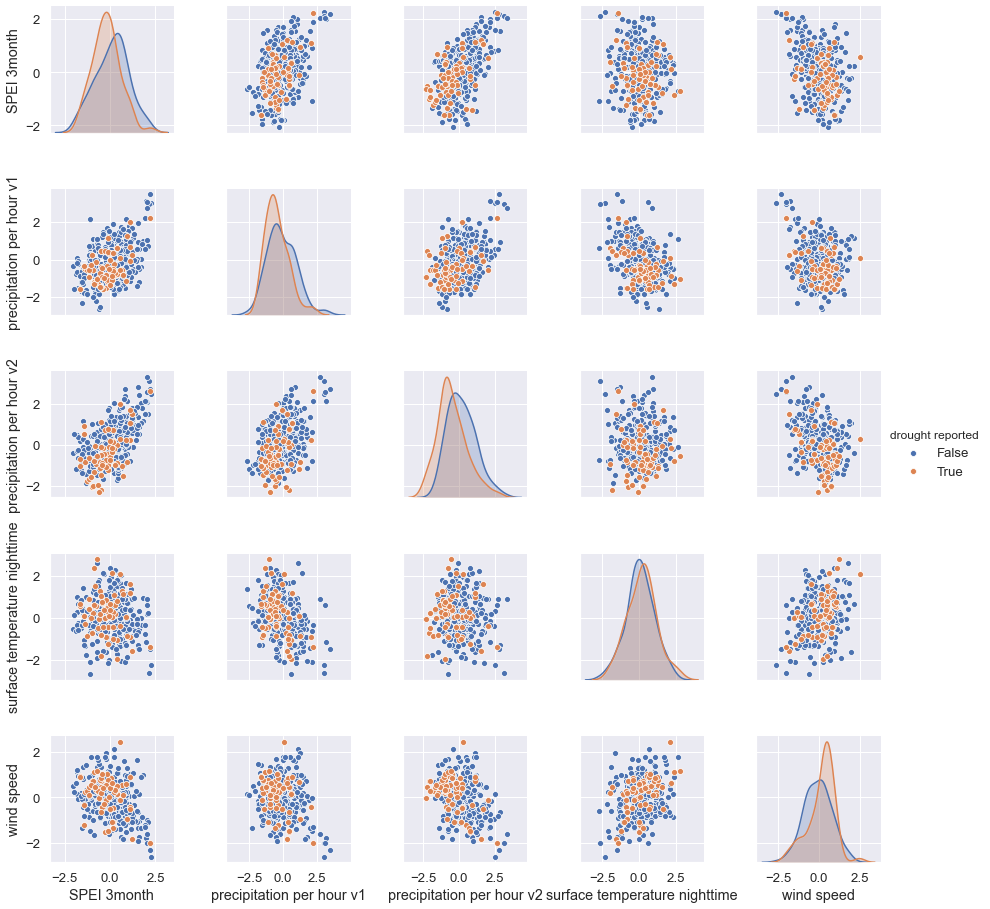

In [60]:
gruop_2 = feature_corr.columns[bicluster_model.row_labels_==2]
sns.pairplot(reduced_data, vars=gruop_2, hue=label_name);

## Correlation with the target

Figures \ref{fig_dist1} to \ref{fig_dist19} show the distribution of each feature separately for '`drought reported =False`' (blue) and '`drought reported = True`' (orange). The medians of the distributions, as well as the absolute values of the difference between them, are reported in Table \ref{tlabe_median}. The features are ranked in descending order according to the difference in medians. From Table \ref{tlabe_median} it is clear that the features that are related to precipitation, either directly or indirectly, are important drought predictors. 

In [22]:
median_vals = reduced_data[All_features+[label_name]].groupby(label_name).median().T.reset_index()
median_vals.rename(columns={True:'yes drought', 
                            False:'no drought', 
                            'Is_drought':'index',
                           'index':'feature'}, inplace= True)
median_vals['difference'] = (median_vals['yes drought']-median_vals['no drought']).abs()
median_vals.sort_values('difference',ascending=False,inplace=True)
median_vals.reset_index(inplace=True,drop=True)
median_vals.columns.name = None 
median_vals

,feature,no drought,yes drought,difference
0,SoilMoisture00 10cm,0.280299,-0.570226,0.850525
1,precipitation per hour v2,0.063213,-0.698218,0.761430
2,SoilMoisture10 40cm,0.216020,-0.530722,0.746742
3,SoilMoisture40 100cm,0.203412,-0.531513,0.734925
4,evapotranspiration,0.044880,-0.602795,0.647675
5,rainfall,0.158049,-0.486975,0.645024
6,SoilTemperature100 200cm,-0.268359,0.320006,0.588365
7,SoilTemperature40 100cm,-0.224721,0.361192,0.585913
8,SoilTemperature10 40cm,-0.211171,0.302455,0.513625
9,SoilTemperature00 10cm,-0.144578,0.340174,0.484752


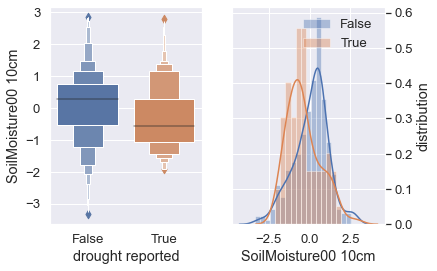

In [115]:
target = 'SoilMoisture00 10cm'
ibf.plot_dist(reduced_data,target,label_name)

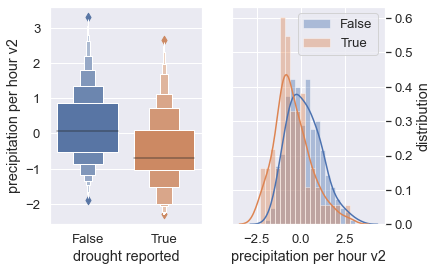

In [63]:
target = 'precipitation per hour v2'
ibf.plot_dist(reduced_data,target,label_name)

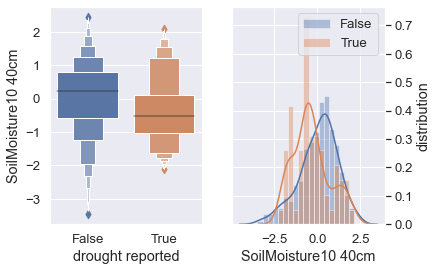

In [64]:
target = 'SoilMoisture10 40cm'
ibf.plot_dist(reduced_data,target,label_name)

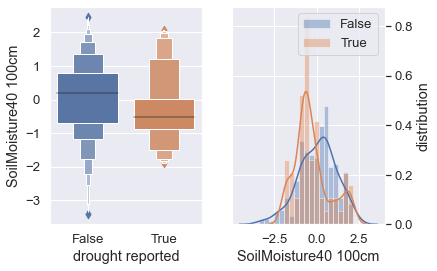

In [65]:
target = 'SoilMoisture40 100cm'
ibf.plot_dist(reduced_data,target,label_name)

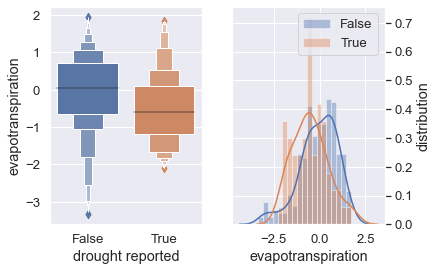

In [66]:
target = 'evapotranspiration'
ibf.plot_dist(reduced_data,target,label_name)

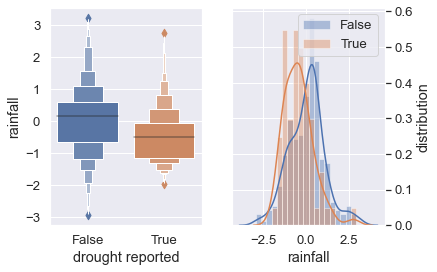

In [67]:
target = 'rainfall'
ibf.plot_dist(reduced_data,target,label_name)

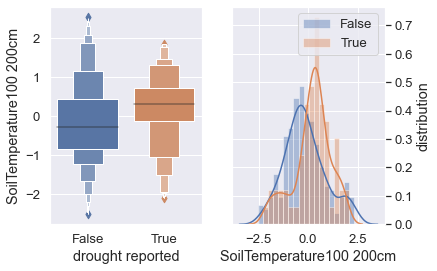

In [68]:
target = 'SoilTemperature100 200cm'
ibf.plot_dist(reduced_data,target,label_name)

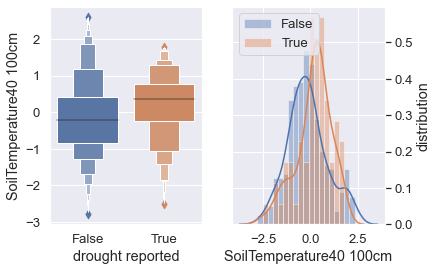

In [69]:
target = 'SoilTemperature40 100cm'
ibf.plot_dist(reduced_data,target,label_name)

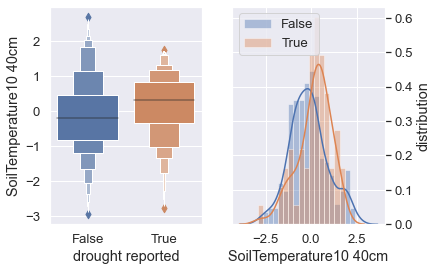

In [70]:
target = 'SoilTemperature10 40cm'
ibf.plot_dist(reduced_data,target,label_name)

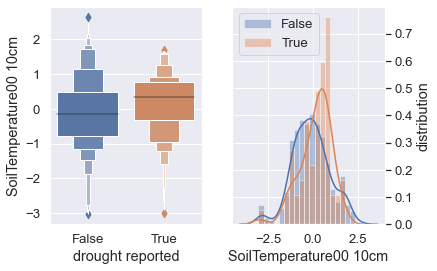

In [71]:
target = 'SoilTemperature00 10cm'
ibf.plot_dist(reduced_data,target,label_name)

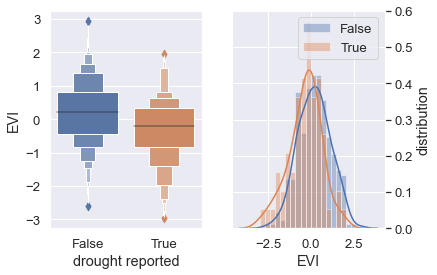

In [72]:
target = 'EVI'
ibf.plot_dist(reduced_data,target,label_name)

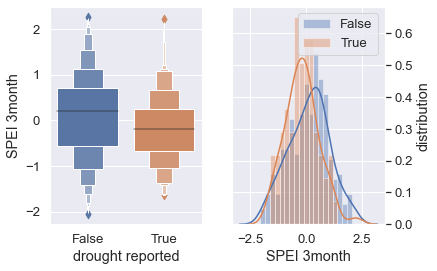

In [73]:
target = 'SPEI 3month'
ibf.plot_dist(reduced_data,target,label_name)

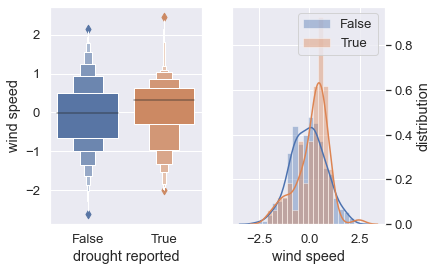

In [74]:
target = 'wind speed'
ibf.plot_dist(reduced_data,target,label_name)

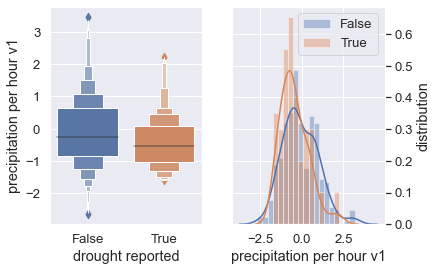

In [75]:
target = 'precipitation per hour v1'
ibf.plot_dist(reduced_data,target,label_name)

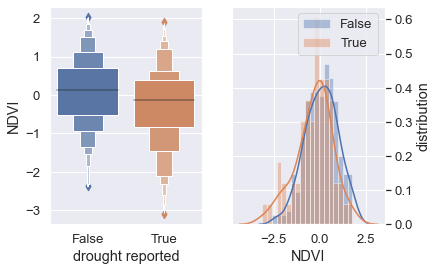

In [76]:
target = 'NDVI'
ibf.plot_dist(reduced_data,target,label_name)

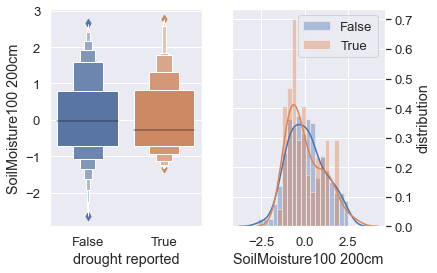

In [77]:
target = 'SoilMoisture100 200cm'
ibf.plot_dist(reduced_data,target,label_name)

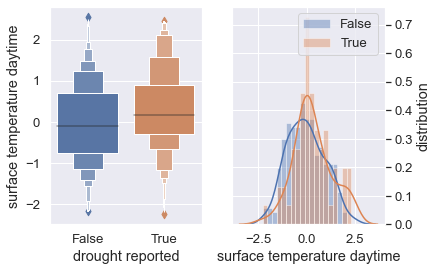

In [78]:
target = 'surface temperature daytime'
ibf.plot_dist(reduced_data,target,label_name)

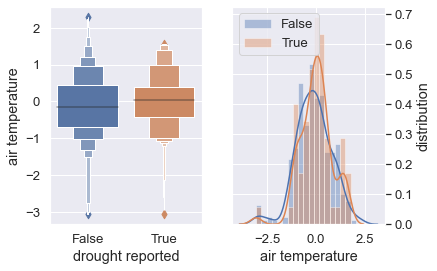

In [79]:
target = 'air temperature'
ibf.plot_dist(reduced_data,target,label_name)

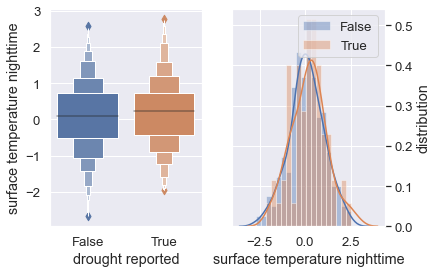

In [80]:
target = 'surface temperature nighttime'
ibf.plot_dist(reduced_data,target,label_name)

# Fitting and optimizing a Logistic Regression model

We train a [logistic regression classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with [$l_1$ penalty](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html) to predict the occurrence of droughts in Uganda. Our goal is to separate the rows of the dataset into two classes: a positive class which represents a drought being reported (`'drought reported' = True`), and a negative class where no drought report exists in the Red Cross desinventar or in the news articles. It is important to note that the population of the positive class $n^{pos}= 65$ in our training data is about 5 times smaller the population of the negative class $n^{neg}= 297$. The negative class is therefore largely overrepresented, and a model trained on such data will be biased towards predicting the negative class correctly, without caring so much about capturing the positive class. Since having a good predicting power for the positive class is equally important for us, we need to correct for this imbalance in the class populations. We do this by assigning unequal weights $W^{pos}$ and $W^{neg}$ to the positive and the negative classes, which are inversely proportional to the class populations:  

\begin{equation}\label{eqn_wpos}
W^{pos}=\frac{\frac{1}{n^{pos}}}{\frac{1}{n^{pos}}+\frac{1}{n^{neg}}},
\end{equation}

and

\begin{equation}\label{eqn_wneg}
W^{neg}=\frac{\frac{1}{n^{neg}}}{\frac{1}{n^{pos}}+\frac{1}{n^{neg}}}.
\end{equation}

Feeding these weights into the logistic regression model guarantees that both classes are represented equally when the model is trained on the data.

In [27]:
np.random.seed(seed=10)

seeds = np.random.randint(1, 100, size=10)

C_array = np.concatenate((np.linspace(0.06,1,100),np.linspace(1,300,100)))

cv_scores = pd.DataFrame()

cv_scores['C'] = C_array

count = 0

for seed in seeds:
    
    count = count+1
    
    X,y,opt_model,mean_test_scores,std_test_scores =ibf.fit_Logreg_model(data, 
                                      selected_features, 
                                      label_name, 
                                      C_array,
                                      n_splits=3, 
                                      shuffle = True, 
                                      shuffle_seed=seed)
    
    cv_scores['shuffle_'+str(count)] = mean_test_scores
    
cv_scores.set_index('C',inplace=True)

The $l_1$ penalty in the logistic regression model is associated with the regularization parameter $C$ which tunes the model complexity, by controlling the number of features which are included in the model. In the framework of logistic regression, the contribution of each feature is determined by a coefficient, and a zero coefficient means that the corresponding feature does not enter the model. The regularization parameter controls how many of the coefficients are different from zero. Figure \ref{fig_l1} shows the model coefficients for all features as a function of the regularization parameter $C$. We can see that for large values of $C$ all coefficients are non-zero. As $C$ decreases, the coefficients gradually shrink to zero.

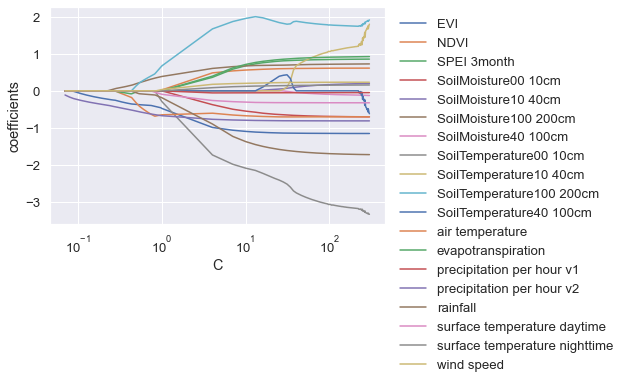

In [116]:
All_coefs = pd.DataFrame()

All_coefs['feature'] = selected_features

C_array = np.concatenate((np.linspace(0.07,1,100),np.linspace(1,300,100)))

fs = []

for C in C_array:
    opt_model.C = C
    opt_model.fit(X,y)
    y_pred = opt_model.predict(X)
    f = ibf.weighted_fscore(y, y_pred)
    fs.append(f)
    All_coefs[C] = opt_model.coef_.ravel()
    
All_coefs = All_coefs.set_index('feature').T.reset_index()
All_coefs.rename(columns={'index':'C'},inplace=True)

to_drop = (All_coefs.std()[All_coefs.std()==0].index)
All_coefs.drop(labels=to_drop,axis=1).plot(logx=True,x='C');
plt.legend(bbox_to_anchor=(1.01, 1));
plt.ylabel('coefficients');

Choosing an appropriate value for the regularization parameter is important, as this systematically eliminates unimportant and redundant features, so that only the most important features remain in the model. We performed [3-fold cross-validation](https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f) to find the best value for $C$, where we used the average [F1 score](https://en.wikipedia.org/wiki/F1_score) as the goodness of fit measure. The average F1 score is given by the weighted sum of the F1 scores for the positive and negative classes: 

\begin{equation}\label{eqn_F}
F1=W^{pos}F1^{pos}+W^{neg}F1^{neg},
\end{equation}

Where $F1^{pos}$ and $F1^{neg}$ are the F1 scores for the positive and negative classes, and $W^{pos}$ and $W^{neg}$ are given by equations \ref{eqn_wpos} and \ref{eqn_wneg} respectively.

To be sure that the outcome of the cross-validation is robust and generalizable, we repeated the procedure 10 times where we randomly shuffled the data before each round of cross-validation. The outcome is demonstrated in Figure \ref{fig_cv}, where the curves in pail colors show the cross-validation average F1 scores as a function of $C$ for each round of shuffling, and the mean of all these curves is shown in dark black. The training average F1 score is also shown in the Figure (dashed-dot curve, green).

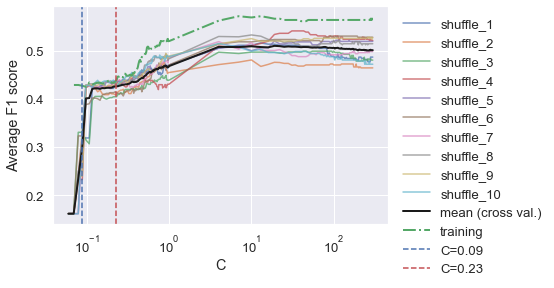

In [120]:
number_nonzero_coefs = All_coefs.set_index('C').astype(bool).sum(axis=1)
points = []
for n in range(1,number_nonzero_coefs.max()):
    point = number_nonzero_coefs[number_nonzero_coefs>n].index[0]
    points.append(point)

cv_scores.plot(logx=True,alpha=0.75)
ax=plt.gca()
cv_scores.mean(axis=1).plot(logx=True,color='k',lw=2,
                            label='mean (cross val.)',ax=ax)
ax=plt.gca()
ax.semilogx(C_array,fs,'-.',color='g',lw=2,label='training')

plt.axvline(x=points[0],color='b',ls='--',
            label='C='+str(round(points[0],2)))
plt.axvline(x=points[1],color='r',ls='--',
           label='C='+str(round(points[1],2)))

plt.ylabel('Average F1 score');
plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1));

Looking at the dark black curve in Figure \ref{fig_cv}, it is clear that for $C<0.09$ (blue vertical dashed line) the cross-validation F1 score rapidly grows by increasing $C$. For values between 0.09 and 0.23 (red vertical dashed line), the cross-validation average F1 score remains relatively constant around 0.42, the same as the training average F1 score (see dashed-dot curve, green). For $C>0.23$, although the training score continues to grow and saturates at 0.57, the cross-validation score always remain below the  training scores and quickly saturates at 0.48 after a mild increase. This implies that for values of $C>0.23$ the model stops to nicely generalize to new data. In other words, the model would have the tendency to overfit to the training data. 

In [138]:
overfit_coefs,_,_,_,_ = ibf.predict_Logreg_model(opt_model, X, y, C=0.3, 
                                              confusion_matrix=False)
overfit_coefs.set_index('feature').apply(lambda x:round(x,2))

,coefficients
feature,
precipitation per hour v2,-0.45
EVI,-0.27
SoilMoisture100 200cm,0.07
air temperature,-0.04
evapotranspiration,-0.02


In the case of our drought model, detecting the overfitting is rather easy, as it leads to intuitively nonsensical models. See, for example, the model coefficients for $C=0.3$ which are listed in Table \ref{tab_overfit}. The coefficient for precipitation is negative, which makes sense, as the precipitation should anticorrelate with droughts. However, the positive coefficient for soil moisture and the negative coefficient for air temperature do not make sense intuitively, indicating that model is fine-tuning itself to the training data. We find that we get more and more of such nonsensical coefficients and we increase $C$ further. Since we inferred from Figure \ref{fig_cv} that the model tends to overfit for $C>0.23$, and the data in Table \ref{tab_overfit} confirms that the overfitting already happens for values as small as 0.3, In the rest of this analysis we used the optimal value of $C=0.23$ for the regularization parameter.

# Model evaluation

A logistic regression model produces a score as a linear combination of the features, where the contribution of each feature is given by its associated coefficient. Table \ref{tab_coefs} lists the nonzero coefficients for our optimal drought model with $C=0.23$. Interestingly, only two features, ‘`precipitation per hour v2`’ and ‘`EVI`’, enter the optimal model. Therefore, according to Table \ref{tab_coefs}, the score produced by our optimal drought model can be written as 

\begin{equation}\label{eqn_score}
\textrm{score}=-0.38\,\times\,\textrm{'precipitation per hour v2'}-0.23\,\times\,\textrm{'EVI'}.
\end{equation}

In [180]:
C=0.225

coefs, predictions, pr, roc, auc = ibf.predict_Logreg_model(opt_model, 
                                                            X, y, C=C, 
                                                            confusion_matrix=False);

In [142]:
coefs.set_index('feature').apply(lambda x:round(x,2))

,coefficients
feature,
precipitation per hour v2,-0.38
EVI,-0.23


Note that, as mentioned earlier, in equation \ref{eqn_score} both feature are normalized per district and per season. The score can be positive or negative, and is a measure for the likelihood of droughts. The more positive the score is, the higher is the chance that a drought occurs. Figure \ref{fig_score} shows the distribution of the score separately for '`drought reported =False`' (blue) and '`drought reported = True`' (orange), confirming that the model score correlates with the target

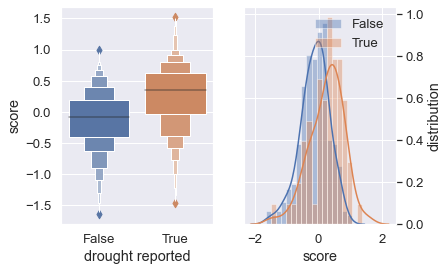

In [144]:
ibf.plot_dist(predictions.rename(columns={'logit_scores':'score'}), 
              'score', label_name)

The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and accuracy associated with the optimal model, as well as [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall) and the F1 scores for positive and negative classes, are given in Text \ref{tab_confusion}. The model reaches the overall accuracy of 60%, and has an impressive recall of ~ 70% for the positive class (which means that the model captures 70% of the reported droughts). On the other hand, the precision for the positive class is rather low: about %25. This is partially due to the overrepresentation of the negative class, which leads to many false positives, and lowers the precision for the positive class as well as the recall for the negative class. We note however that there is a rather high chance that an actual drought in Uganda remain unreported. We therefore expect that the number of false positives presented in Text \ref{tab_confusion} is an overestimation. The actual predictive power of the model can only be assessed after testing it in the field.  

In [179]:
coefs, predictions, pr, roc, auc = ibf.predict_Logreg_model(opt_model, 
                                                            X, y, C=C, 
                                                            confusion_matrix=True);

                 Confusion matrix
                 Score positive    Score negative
Actual positive        45                20
Actual negative       127               170

Accuracy  0.59
 
           Positive      Negative
Num case       65           297
Precision    0.26          0.89
Recall       0.69          0.57
F-score      0.38          0.70


Weighted Average F-score  0.44


To have a baseline with which we can compare the performance of our model, we consider a “random model” which classifies the data by “coin flipping”: irrespective to the features values, the model assigns `True` and `False` labels to the data points with equal probability. Text \ref{tab_random} lists the fit quality metric for such a random model (averaged over 100 runs). We see that our model clearly outperforms the random model in every aspect, especially in the case of the positive class.

In [32]:
_,_= ibf.fit_random_model(y)

           Positive      Negative
Precision    0.18          0.82
Recall       0.50          0.50
F_score      0.26          0.62


Figures \ref{fig_pr} and \ref{fig_roc} show the [precision-recall curve](https://acutecaretesting.org/en/articles/precision-recall-curves-what-are-they-and-how-are-they-used) and the [receiver operating characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the optimal model. The area under the ROC curve ([auc](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)) is a metric commonly used to assess the predictive power of binary classifiers. A perfect classifier has an auc of one, while for a random classifier auc equals 0.5. Our model reaches auc of 0.7.

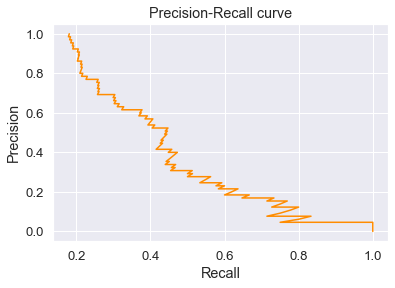

In [146]:
plt.plot(pr[0],pr[1],color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision');
plt.title('Precision-Recall curve');

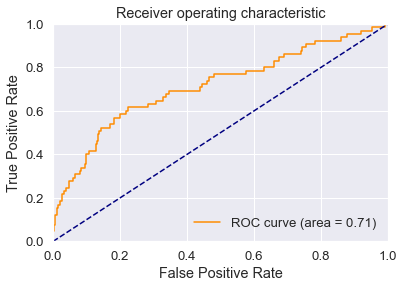

In [145]:
plt.plot(roc[0],roc[1],color='darkorange',
         label='ROC curve (area = %0.2f)' % auc)
plt.plot([0,1],[0,1],'--',color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic');

# Drought prediction: successes and failures   

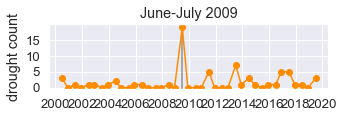

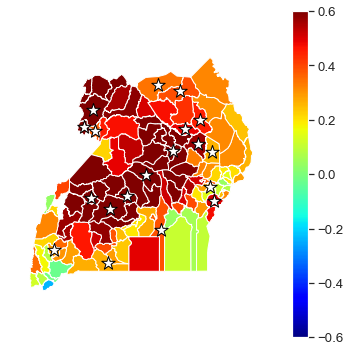

In [178]:
year = 2009
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

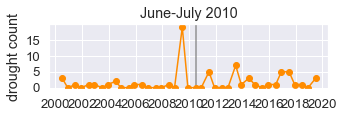

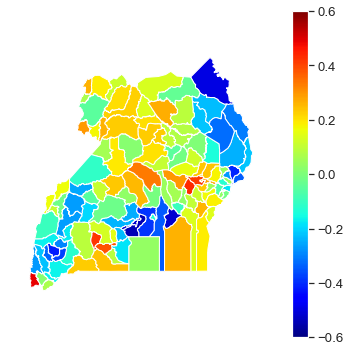

In [148]:
year = 2010
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

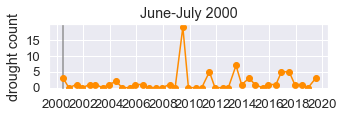

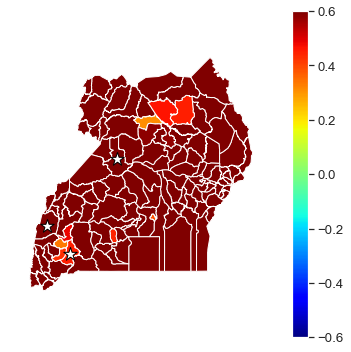

In [149]:
year = 2000
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

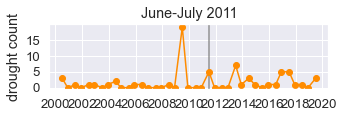

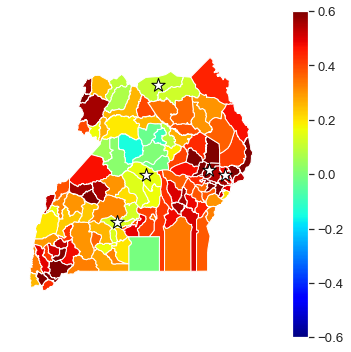

In [150]:
year = 2011
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

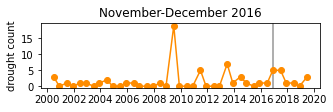

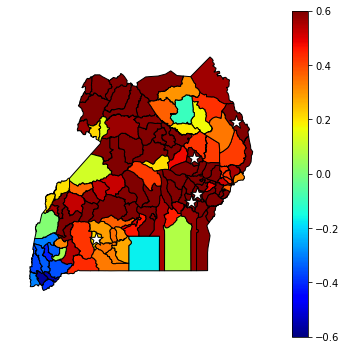

In [41]:
year = 2016
season = '11_12'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)


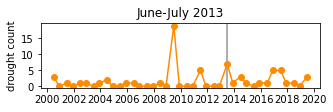

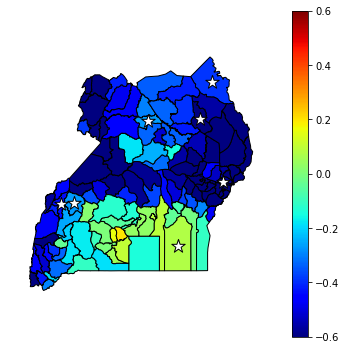

In [42]:
year = 2013
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

Anomaly in 2013

In [43]:
data_nolag = ibf.prepare_Uganda_data(first_planting = [5,6,7],
                       second_planting = [10,11,12])

selected_features_nolag = list(data_nolag.drop(labels=id_cols+[label_name],axis=1).columns)

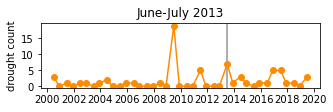

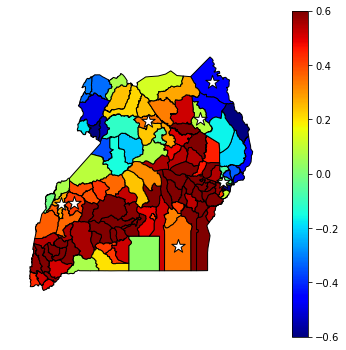

In [44]:
year = 2013
season = '6_7'

ibf.visualize_droughts_uganda(data_nolag,opt_model,year,season,
                              selected_features=selected_features_nolag,
                             label_name=label_name)

# Generalizing the Model towards a Drought Monitoring System

In [48]:
monitor_features = ['precipitation per hour v2', 'EVI']
### reconstructing the optimal model with two features
monitor_model = ibf.make_monitor_model(data, monitor_features, label_name,
                                   C=0.225)
label_col = label_name
date_col = 'date'

monitor_data = ibf.prepare_monitor_data(Uganda_data,monitor_features,
                                    monitor_model,label_col=label_name)

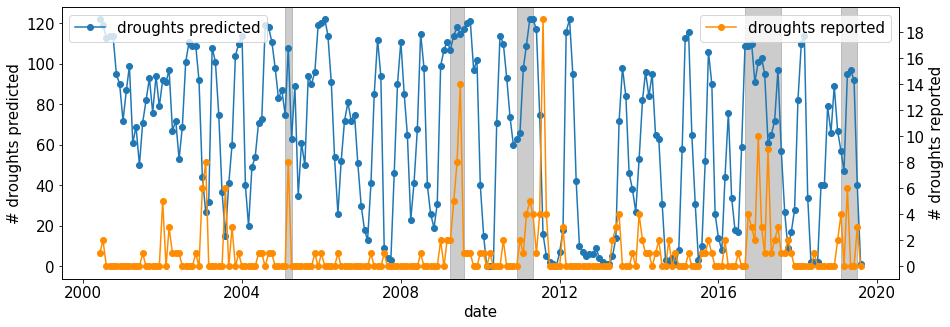

In [49]:
drought_count = monitor_data[[date_col,label_col,'drought_predicted']].groupby(date_col).sum()

plt.figure(figsize=(15,5))
plt.plot(drought_count.index,drought_count['drought_predicted'],marker='o')
plt.xlabel('date',fontsize=15)
plt.ylabel('# droughts predicted',fontsize=15)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.legend(['droughts predicted'],loc=2,fontsize=15)
ax=plt.gca()
ax2=ax.twinx()
ax2.plot(drought_count.index,drought_count[label_col],marker='o',color='darkorange')
plt.ylabel('# droughts reported',fontsize=15)
plt.yticks(range(0, 20, 2),fontsize=15);
plt.legend(['droughts reported'],loc=1,fontsize=15)
date_1 = date(2005, 2, 1)
date_2 = date(2005,4, 1)
ax.axvspan(date_1, date_2, alpha=0.4, color='grey')
date_1 = date(2009, 4, 1)
date_2 = date(2009,8, 1)
ax.axvspan(date_1, date_2, alpha=0.4, color='grey')
date_1 = date(2010, 12, 1)
date_2 = date(2011,5, 1)
ax.axvspan(date_1, date_2, alpha=0.4, color='grey')
date_1 = date(2016, 9, 1)
date_2 = date(2017,8, 1)
ax.axvspan(date_1, date_2, alpha=0.4, color='grey')
date_1 = date(2019, 2, 1)
date_2 = date(2019,7, 1)
ax.axvspan(date_1, date_2, alpha=0.4, color='grey');

In [52]:
date_picker=widgets.DatePicker(
    description='Pick a Date',
    disabled=False,
    value = date(2009,7,1)
)

def monitor(monitor_date):
    ibf.monitor_plot(monitor_data,monitor_date,label_col=label_name)

#interact(monitor,monitor_date=date_picker)

In [ ]:
# Appendix: Global Drought Prediction
#years = data.year.unique()
#for year in years:
#    seasons = np.flip(data[data.year==year]['Season'].unique())
#    for season in seasons:
#        ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
#                             label_name)
        